In [29]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.chdir('drive/MyDrive/paperBuild/Compressor/data')

In [15]:
!ls

data_0_1_.dat  data_2_0_.dat  data_4_0_.dat  data_6_0_.dat
data_1_0_.dat  data_3_1_.dat  data_5_1_.dat  data_7_1_.dat


In [16]:
channels=[[4,5,6,7,8],[14,13,12,11,15],[18,19,20,21,22],[24,25,26,0,1]]
pressurecoeff=[[ 1580.1, 1595, 1457.4, 1450.1, 1414.1],[1204.9, 1048.4, 1185.7, 1191.5, 1201.4],[1194.7, 1201.2, 1194.5, 1851.9, 1773.9],[1198, 1203.4, 1199.7, 1299.9, 2077.2]]
hall=[3]
threshold=2.5 # 0~5

In [40]:
# data per revolution: 50000 samples/sec / (2400/60) =  1250
perRev=1250
# 2400 rpm 50KHz Blade Passage 60: 20 samples per passage per revolution
rev=10 # 10 revolution data considered between last 20 rev. to last 10 rev.
datapts=64 # 4 chords, before and after hall flags give 8 datapoints for each file.
# 8 files (4 no stall and 4 stall) generating 64 time series data. Each chord has
# specific pressure coefficient.
samples=20
chord_probes=5
batch=np.arange(0,datapts,2*len(channels))
dp=np.zeros([datapts,rev-2, samples, chord_probes]) # Trim 1st and last rev.

In [18]:
def hall_reform(hall_logic, threshold):
  data=hall_logic.values
  for i in range(len(data)):
    data[i] = 0 if data[i]>threshold else 1

  return data

def indices_work(hall_flag):
  temp=np.array([])
  for i in range(len(hall_flag)):
    if hall_flag[i]==1:
      temp=np.append(temp, i+1)

  return temp

In [41]:
p=0
for item in os.listdir():
  raw=pd.read_fwf(item, header=None)
  raw=raw.iloc[-20*perRev: -10*perRev,:]
  hall_logic=raw.iloc[:,hall]
  hall_logic=hall_reform(hall_logic, threshold)
  hall_flag=hall_logic[1:]-hall_logic[:-1] # Transition from high to low or low to high
  indices=indices_work(hall_flag)
  indices=indices.astype(int)

  for chord in np.arange(0,len(channels)):
    #for p in batch:
    #chord=0
    dataR=np.zeros([len(indices)-2, samples, len(channels[chord][:])]) # Revolution, time series, sensors
    dataL=np.zeros([len(indices)-2, samples, len(channels[chord][:])])
    n=0 # Revolution count
    coefficients=pressurecoeff[chord][:]
    for m in indices[1:-1]: #Revolution/Hall trigger for one file
      dataR[n]=raw.iloc[m:m+samples, channels[chord][:]].values # any coefficient multiplication should be done here
      dataR[n]=np.multiply(dataR[n], coefficients)
      dataR[n]=preprocessing.normalize(dataR[n])
      dataL[n]=raw.iloc[m-samples:m, channels[chord][:]].values # any coefficient multiplication should be done here
      dataL[n]=np.multiply(dataL[n], coefficients)
      dataL[n]=preprocessing.normalize(dataL[n])
      n=n+1

    dp[p]=dataR
    dp[p+1]=dataL
    p=p+2

    #break



In [42]:
dp.shape

(64, 8, 20, 5)

In [44]:
dp[63][0]

array([[-0.35615619, -0.4965784 , -0.63133116, -0.46842874,  0.09251024],
       [-0.36061519, -0.55377693, -0.60090968, -0.42930384,  0.13376685],
       [-0.38548212, -0.61821348, -0.53602389, -0.39550423,  0.15959456],
       [-0.44229439, -0.6593838 , -0.5027737 , -0.29214993,  0.17735754],
       [-0.50049151, -0.68272773, -0.46973708, -0.20812728,  0.13936001],
       [-0.55654826, -0.68541161, -0.4388096 , -0.14444308,  0.08394818],
       [-0.60206099, -0.67946105, -0.4093668 , -0.09032693,  0.0107295 ],
       [-0.65372977, -0.65187824, -0.37999848, -0.01500972,  0.05538957],
       [-0.68758904, -0.62859082, -0.34558066,  0.00140672,  0.1125474 ],
       [-0.7068939 , -0.60903321, -0.32192858,  0.04791149,  0.15312099],
       [-0.71513635, -0.5887959 , -0.32400036,  0.06880037,  0.17941476],
       [-0.73673023, -0.55337466, -0.32597417,  0.08082097,  0.19548369],
       [-0.7463304 , -0.5395088 , -0.33011059,  0.11150913,  0.17468227],
       [-0.77391532, -0.53682663, -0.3

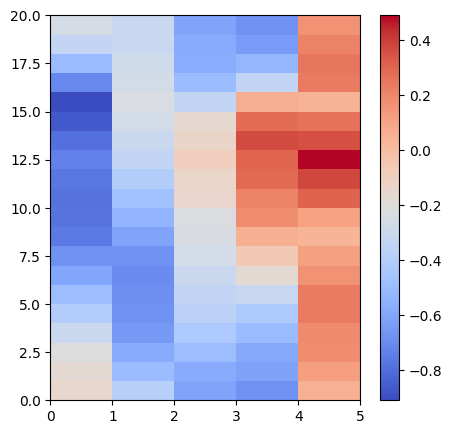

In [48]:
fig, ax = plt.subplots(figsize=(5,5))
pcm = ax.pcolormesh(dp[0][0], cmap='coolwarm')
#pcm.set_clim(min(dp[0][0].reshape(-1)),max(dp[0][0].reshape(-1)))
fig.colorbar(pcm, ax=ax)
#ax.axis('off')
plt.show()

In [49]:
data_=dp[0]
data_[data_==0]=0.0000001

In [ ]:
layers=5

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, x, y = data_[0:layers].nonzero()
ax.scatter(x, y, z, c=data_[0:layers].reshape(-1), alpha=1)
plt.show()